## Current idea of process flow:
 - encoding
     - fft the audio
     - filter high frequency components
     - keep only positive frequencies and round to integer
     - encode the audio into the image
 - decoding
     - decode the audio from the image
     - ifft the frequency components

In [1]:
import cv2
import jpeglib
import librosa
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
import soundfile as sf

from scipy.fft import fft, ifft, fft2, ifft2, fftfreq, fftshift, dct, idct
from PIL import Image

In [22]:
img_path = "../bird.jpg"
audio_paths = [
    "../BengawanSolo.m4a", 
    "../BridgeOverTroubledWater.m4a", 
    "../ChanMaliChan.m4a", 
    "../CountryRoad.m4a", 
    "../Edelweiss.m4a", 
    "../FourSeasons.m4a", 
    "../GoodBadUgly.m4a",
    "../HighMountainGreen.m4a", 
    "../MunneruVaaliba.m4a", 
    "../ScarboroughFair.m4a", 
    "../SingSingSo.m4a", 
    "../SoundOfSilence.m4a", 
    "../SpringBreeze.m4a", 
    "../TongNian.m4a", 
    "../WaltzingMatilda.m4a"
]

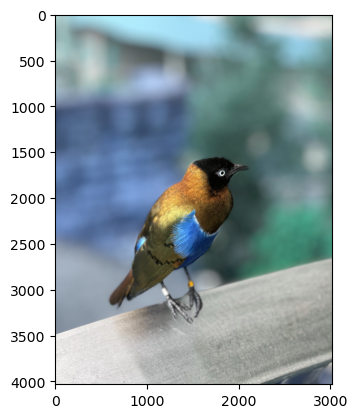

In [3]:
img = cv2.imread(img_path)
plt.imshow(img)

In [32]:
audios = []
audio_ffts = []
fs = 44100
for pth in audio_paths:
    audio, fs = librosa.load(pth, sr=None)
    print(4032*3024 - len(audio)/2*16/2)
    audios.append(audio)
    
    audio_fft = fft(audio)
    audio_ffts.append(audio_fft)
    # print(f"max: {np.max(audio_fft.real)}, {np.max(audio_fft.imag)}, min: {np.min(audio_fft).real}, {np.min(audio_fft).imag}")


/var/folders/kw/s9c95h691ds9ltpqkjx0s0_40000gn/T/ipykernel_56091/2426468262.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, fs = librosa.load(pth, sr=None)


-4345480.0
-2858764.0
890196.0
-4697476.0
2364528.0
3325712.0
-7565304.0
1234348.0
1649260.0
-11422120.0
456564.0
-34648.0
1114652.0
-1378336.0
-1628776.0


In [5]:
audio.shape

(3392776,)

In [6]:
def get_half_fft(audio, filter_num=1524096):
    audio_fft = fft(audio)
    n = len(audio)
    return fftshift(audio_fft)[n//2-filter_num: n//2], filter_num

In [7]:
def get_audio(half_fft):
    n = 2*len(half_fft)
    neg_fft = np.conj(half_fft[::-1])
    full_fft = np.zeros(n, dtype=complex)
    full_fft[:n//2] = half_fft
    full_fft[n//2:] = neg_fft
    
    audio = np.real(ifft(fftshift(full_fft)))
    return audio

In [8]:
filter_num = img.shape[0] * img.shape[1] // 8

half_fft, filter_num = get_half_fft(audio, filter_num)
half_fft = np.round(half_fft)
newfs = fs*2*filter_num//n
# --> pack: { data, newfs }
audio_10000 = get_audio(half_fft)

In [9]:
print(np.max(np.real(half_fft)))
print(np.max(np.imag(half_fft)))

3476.0
3416.0


In [21]:
print(np.min(np.real(half_fft)))
print(np.min(np.imag(half_fft)))

-3682.0
-4151.0


#### Observed that the max values < range of int16, so use int16 to reduce numbers to encode

In [10]:
real = np.real(half_fft).astype('int16')
imag = np.imag(half_fft).astype('int16')

In [11]:
real.shape

(1524096,)

In [12]:
def encode_channel(ch, arr):
    arr_flat = arr.reshape(-1, 1)
    bin = (np.right_shift(arr_flat, [14, 12, 10, 8, 6, 4, 2, 0]) & 0b11).reshape(ch.shape)

    res = ((ch & 0b11111100) | (bin & 0b11)).astype('uint8')
    return res


def encode(img, audio, filter_num):
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(img_ycrcb)
    
    half_fft, _ = get_half_fft(audio, filter_num)
    half_fft = np.round(half_fft)

    real, imag = half_fft.real, half_fft.imag

    cr1 = encode_channel(cr, real)
    cb1 = encode_channel(cb, imag)
    
    img_ycrcb1 = cv2.merge([y, cr1, cb1])
    img1 = cv2.cvtColor(img_ycrcb1, cv2.COLOR_YCrCb2BGR)
    
    return img1
    

In [13]:
sd.play(audio_10000, newfs)

In [14]:
sd.stop()

In [15]:
audio.shape

(3392776,)

In [16]:
img.shape

(4032, 3024, 3)

In [17]:
img_ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

y1, cb1, cr1 = cv2.split(img_ycbcr)

In [18]:
im = jpeglib.read_dct(img_path)
qy, qc = im.qt

In [19]:
print(qy)
print(qc)

[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]


#### Observed that quantization tables of ycbcr domains are all 1s, so lossless compression here....

In [20]:
filter_num = 1524096
res = encode(img, audio, filter_num)

TypeError: ufunc 'right_shift' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
plt.imshow(res)

In [ ]:
fig, ax = plt.subplots(2)
ax[0].imshow(img)
ax[1].imshow(rgb_img)